## Содержание
1. Базовые вспомогательные компоненты
2. Задача 1 — слой `BatchNorm`
3. Задача 2 — слой `Linear`
4. Задача 3 — слой `Dropout`
5. Демонстрация работы собственного мини-фреймворка
6. Задание 2 — медианный фильтр
7. Задание 3 — собственные аугментации (`BaseTransform`, `RandomCrop`, `RandomRotate`, `ToTensor`, `Compose`)
8. Задание 4 — применение аугментаций в классификаторе из практики 2.2


## 1. Базовые вспомогательные компоненты


In [1]:
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

plt.style.use("seaborn-v0_8")
# Фиксируем генераторы случайных чисел, чтобы ноутбук воспроизводился
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Базовая директория проекта и данных
DATA_ROOT = Path("/home/egormerk/VSCodeProjects/spbu_dl_2025")


Ниже определены минимальные строительные блоки: базовый класс слоя, функция записи параметров и простой оптимизатор SGD без использования `torch.nn`.


In [2]:
class Layer:
    """Базовый интерфейс слоя с ручным управлением train/eval."""

    def __init__(self) -> None:
        self.training = True

    def train(self) -> "Layer":
        self.training = True
        return self

    def eval(self) -> "Layer":
        self.training = False
        return self

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def parameters(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        """Возвращает пары (параметр, градиент)."""
        return []


def glorot_uniform(in_features: int, out_features: int) -> torch.Tensor:
    """Инициализация весов по Глороту для стабильного старта."""
    limit = math.sqrt(6.0 / (in_features + out_features))
    return torch.empty(out_features, in_features).uniform_(-limit, limit)


class Sequential(Layer):
    def __init__(self, *layers: Layer) -> None:
        super().__init__()
        self.layers = list(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

    def parameters(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        params: List[Tuple[torch.Tensor, torch.Tensor]] = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params


class SGDOptimizer:
    def __init__(self, layers: Iterable[Layer], lr: float = 1e-2, weight_decay: float = 0.0) -> None:
        self.layers = list(layers)
        self.lr = lr
        self.weight_decay = weight_decay

    def zero_grad(self) -> None:
        for param, grad in self._parameters():
            grad.zero_()

    def step(self) -> None:
        for param, grad in self._parameters():
            if self.weight_decay:
                # L2-регуляризация учитывается как weight decay
                param -= self.lr * (grad + self.weight_decay * param)
            else:
                param -= self.lr * grad

    def _parameters(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        params: List[Tuple[torch.Tensor, torch.Tensor]] = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params


## 2. Задача 1 — реализация класса `BatchNorm`


Реализуем 1D-вариант слоя пакетной нормализации без использования `torch.nn`. Слой поддерживает режимы `train/eval`, хранит скользящие оценки среднего и дисперсии и вычисляет градиенты вручную.


In [3]:
class BatchNorm1d(Layer):
    def __init__(self, num_features: int, momentum: float = 0.1, eps: float = 1e-5) -> None:
        super().__init__()
        self.num_features = num_features
        self.momentum = momentum
        self.eps = eps
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        self._cache: dict[str, torch.Tensor] = {}
        self.grad_gamma = torch.zeros_like(self.gamma)
        self.grad_beta = torch.zeros_like(self.beta)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() != 2:
            raise ValueError("BatchNorm1d ожидает вход размера (batch, features)")

        if self.training:
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)
            # Обновляем скользящие оценки по формуле из оригинальной статьи
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            std_inv = torch.rsqrt(batch_var + self.eps)
            x_hat = (x - batch_mean) * std_inv
            self._cache = {
                "x_hat": x_hat,
                "std_inv": std_inv,
                "x_centered": x - batch_mean,
                "batch_size": torch.tensor(x.shape[0], dtype=torch.float32),
            }
        else:
            # На инференсе используем накопленные статистики
            std_inv = torch.rsqrt(self.running_var + self.eps)
            x_hat = (x - self.running_mean) * std_inv
            self._cache = {}

        return self.gamma * x_hat + self.beta

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        if not self._cache:
            raise RuntimeError("Backward вызван до forward в режиме обучения")

        x_hat = self._cache["x_hat"]
        std_inv = self._cache["std_inv"]
        x_centered = self._cache["x_centered"]
        batch_size = int(self._cache["batch_size"].item())

        self.grad_gamma = torch.sum(grad_output * x_hat, dim=0)
        self.grad_beta = torch.sum(grad_output, dim=0)

        dx_hat = grad_output * self.gamma
        # Градиенты дисперсии и среднего повторяют вывод из практики по BatchNorm
        dvar = torch.sum(dx_hat * x_centered * -0.5 * (std_inv ** 3), dim=0)
        dmean = torch.sum(dx_hat * -std_inv, dim=0) + dvar * torch.mean(-2.0 * x_centered, dim=0)
        grad_input = dx_hat * std_inv + (2.0 / batch_size) * x_centered * dvar + dmean / batch_size
        return grad_input

    def parameters(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        return [(self.gamma, self.grad_gamma), (self.beta, self.grad_beta)]


## 3. Задача 2 — реализация слоя `Linear`


Слой принимает батч размерности `(batch, in_features)` и возвращает `(batch, out_features)` с ручным вычислением градиентов по весам и смещениям.


In [4]:
class Linear(Layer):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = glorot_uniform(in_features, out_features)
        self.bias = torch.zeros(out_features)
        self.grad_weight = torch.zeros_like(self.weight)
        self.grad_bias = torch.zeros_like(self.bias)
        self._input: torch.Tensor | None = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.shape[1] != self.in_features:
            raise ValueError("Неверное число входных признаков")
        self._input = x
        return x @ self.weight.T + self.bias

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        if self._input is None:
            raise RuntimeError("Backward вызван до forward")
        # Средние градиенты по батчу: dL/dW = (dL/dout)^T * x / N
        self.grad_weight = grad_output.T @ self._input / self._input.shape[0]
        self.grad_bias = grad_output.mean(dim=0)
        grad_input = grad_output @ self.weight
        return grad_input

    def parameters(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        return [(self.weight, self.grad_weight), (self.bias, self.grad_bias)]


## 4. Задача 3 — слой `Dropout`


Слой реализует отключение нейронов с заданной вероятностью во время обучения и масштабирование активаций на инференсе.


In [5]:
class Dropout(Layer):
    def __init__(self, p: float = 0.5) -> None:
        super().__init__()
        if not 0 <= p < 1:
            raise ValueError("p должен быть в [0, 1)")
        self.p = p
        self.mask: torch.Tensor | None = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            # Маска берётся из Бернулли и масштабируется по правилу inverted dropout
            self.mask = torch.bernoulli(torch.full_like(x, 1 - self.p)) / (1 - self.p)
            return x * self.mask
        self.mask = None
        return x

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        if self.training:
            if self.mask is None:
                raise RuntimeError("Нет маски для backward")
            return grad_output * self.mask
        return grad_output


> Для примеров ниже понадобится нелинейность, поэтому определим вспомогательный слой ReLU (он используется только утилитарно, без притязаний на дополнительные баллы).


In [6]:
class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.mask: torch.Tensor | None = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Сохраняем маску активных нейронов для обратного прохода
        self.mask = (x > 0).to(x.dtype)
        return x * self.mask

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        if self.mask is None:
            raise RuntimeError("Нет маски для backward")
        return grad_output * self.mask


## 5. Демонстрация работы собственного мини-фреймворка

Потренируем небольшую сеть `Linear → ReLU → BatchNorm → Dropout → Linear` на синтетическом наборе из двух гауссиан. Для справедливости градиенты считаем вручную, лосс — бинарная кросс-энтропия.


In [7]:
def make_toy_dataset(n_per_class: int = 512) -> Tuple[torch.Tensor, torch.Tensor]:
    """Две гауссианы с разными средними для быстрой проверки слоёв."""
    mean0 = torch.tensor([-1.5, -1.0])
    mean1 = torch.tensor([1.5, 1.0])
    cov = torch.tensor([[1.0, 0.3], [0.3, 1.0]])
    dist = torch.distributions.MultivariateNormal(torch.zeros(2), covariance_matrix=cov)
    x0 = dist.sample((n_per_class,)) + mean0
    x1 = dist.sample((n_per_class,)) + mean1
    x = torch.cat([x0, x1], dim=0)
    y = torch.cat([torch.zeros(n_per_class), torch.ones(n_per_class)])[:, None]
    perm = torch.randperm(len(x))
    return x[perm], y[perm]


def binary_cross_entropy_with_logits(logits: torch.Tensor, targets: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    probs = torch.sigmoid(logits)
    eps = 1e-7
    loss = -(targets * torch.log(probs + eps) + (1 - targets) * torch.log(1 - probs + eps)).mean()
    grad = (probs - targets) / targets.shape[0]
    return loss, grad


def train_custom_model(epochs: int = 200, lr: float = 0.5) -> dict[str, List[float]]:
    x, y = make_toy_dataset()
    split = int(0.8 * len(x))
    x_train, y_train = x[:split], y[:split]
    x_val, y_val = x[split:], y[split:]

    layers: List[Layer] = [
        Linear(2, 16),
        ReLU(),
        BatchNorm1d(16),
        Dropout(0.1),
        Linear(16, 1),
    ]
    optimizer = SGDOptimizer(layers, lr=lr)
    history = {"loss": [], "val_acc": []}

    for epoch in range(epochs):
        # Прямой и обратный проходы через последовательность кастомных слоёв
        for layer in layers:
            layer.train()
        logits = x_train
        for layer in layers:
            logits = layer.forward(logits)
        loss, grad = binary_cross_entropy_with_logits(logits, y_train)
        for layer in reversed(layers):
            grad = layer.backward(grad)
        optimizer.step()
        optimizer.zero_grad()
        history["loss"].append(float(loss.item()))

        # Валидация
        for layer in layers:
            layer.eval()
        val_logits = x_val
        for layer in layers:
            val_logits = layer.forward(val_logits)
        val_pred = (torch.sigmoid(val_logits) > 0.5).float()
        val_acc = (val_pred == y_val).float().mean().item()
        history["val_acc"].append(val_acc)
    history["model"] = layers
    history["data"] = (x_train, y_train, x_val, y_val)
    return history


history = train_custom_model(epochs=150, lr=0.8)
print(f"Финальный loss: {history['loss'][-1]:.4f}, val_acc: {history['val_acc'][-1]:.3f}")


Финальный loss: 0.1419, val_acc: 0.951


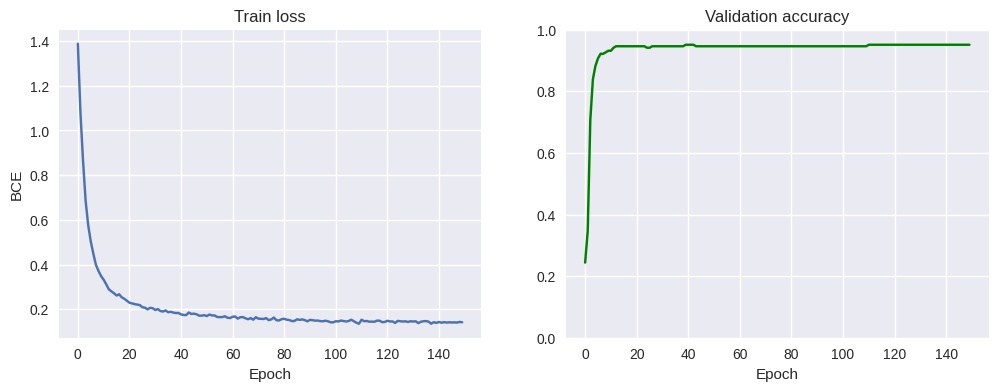

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history["loss"])
axes[0].set_title("Train loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE")
axes[1].plot(history["val_acc"], color="green")
axes[1].set_title("Validation accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylim(0, 1)
plt.show()


## 6. Задание 2 — медианный фильтр (ядра 3×3, 5×5, 10×10)

Фильтр реализован через `unfold` и работает с тензорами формата `(C, H, W)`. Для демонстрации используем изображение из папки `images/kitten.jpg`.


In [9]:
def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    """Переводит PIL.Image в нормализованный тензор (C, H, W)."""
    np_img = np.array(img)
    if np_img.ndim == 2:
        np_img = np_img[:, :, None]  # добавляем канал для градиентных изображений
    elif np_img.ndim == 3 and np_img.shape[2] == 4:
        np_img = np_img[:, :, :3]
    tensor = torch.from_numpy(np.ascontiguousarray(np_img)).permute(2, 0, 1).float() / 255.0
    return tensor


def tensor_to_pil(t: torch.Tensor) -> Image.Image:
    """Обратное преобразование, удобно для визуализации."""
    arr = torch.clamp(t * 255.0, 0, 255).byte().permute(1, 2, 0).numpy()
    return Image.fromarray(arr)


def median_filter(image: torch.Tensor, kernel_size: int) -> torch.Tensor:
    if image.dim() != 3:
        raise ValueError("Ожидается тензор (C, H, W)")
    if kernel_size < 1:
        raise ValueError("Размер ядра должен быть >= 1")
    pad_before = kernel_size // 2
    pad_after = kernel_size - pad_before - 1
    pad_config = ((0, 0), (pad_before, pad_after), (pad_before, pad_after))
    # Для чётных окон используем несимметричное дополнение, чтобы сохранить размеры изображения
    padded = torch.from_numpy(np.pad(image.numpy(), pad_config, mode="reflect"))
    # unfold превращает каждое окно k×k в последний размер, далее берём медиану
    unfolded = padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1)
    windows = unfolded.contiguous().view(image.shape[0], image.shape[1], image.shape[2], -1)
    median = windows.median(dim=-1).values
    return median


original_img = Image.open(DATA_ROOT / "images/kitten.jpg").convert("RGB")
tensor_img = pil_to_tensor(original_img)
filtered_imgs = {k: median_filter(tensor_img, k) for k in (3, 5, 10)}


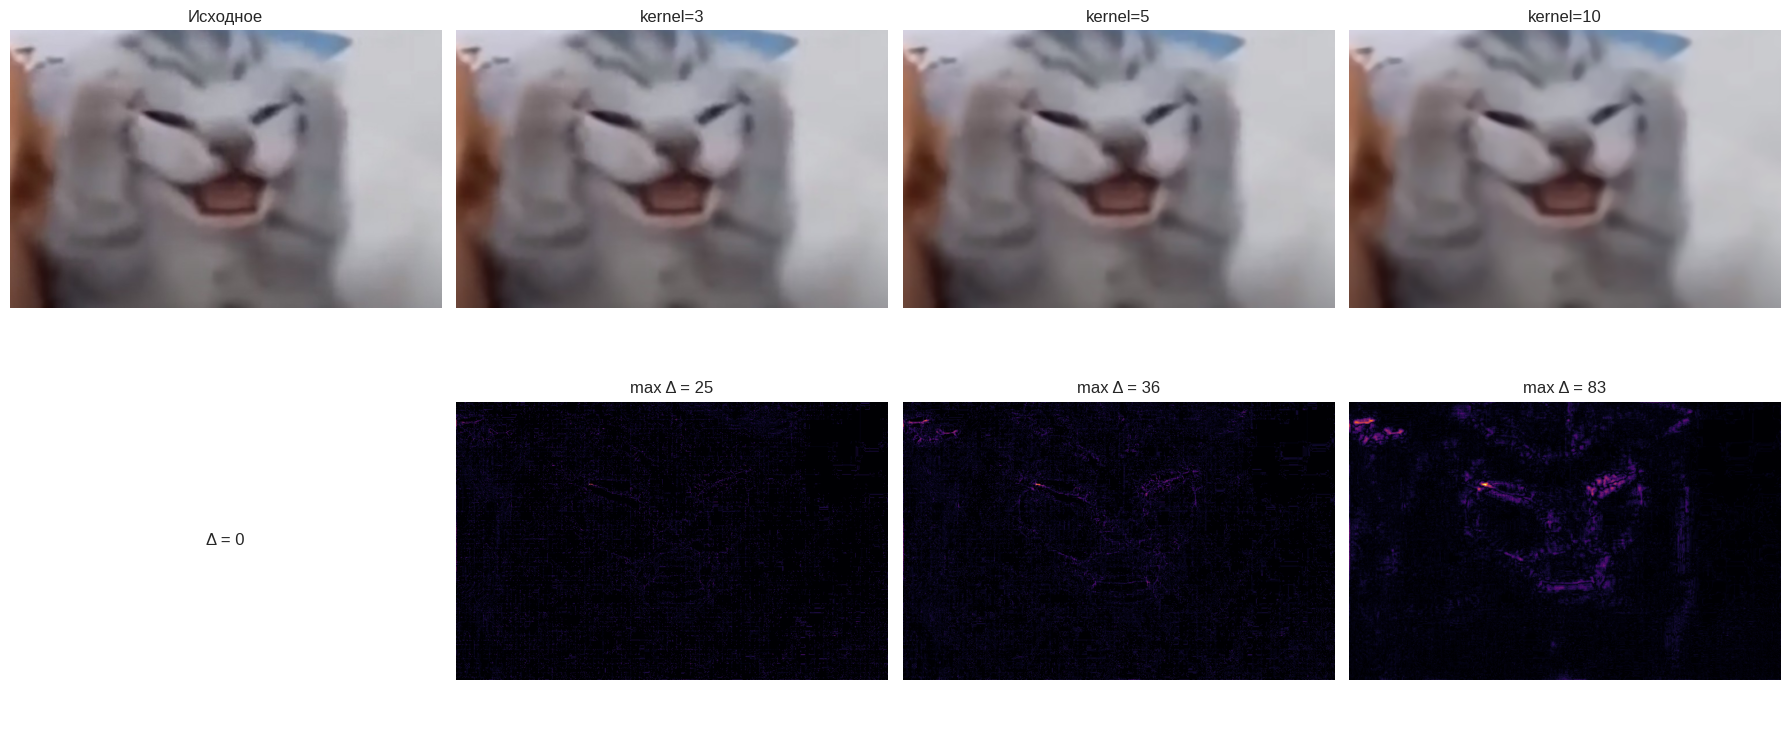

In [15]:
orig_arr = np.asarray(original_img, dtype=np.int16)
cols = len(filtered_imgs) + 1
fig, axes = plt.subplots(2, cols, figsize=(4.5 * cols, 8))
axes = np.array(axes)

axes[0, 0].imshow(original_img)
axes[0, 0].set_title("Исходное")
axes[0, 0].axis("off")
axes[1, 0].axis("off")
axes[1, 0].text(0.5, 0.5, "Δ = 0", ha="center", va="center", fontsize=12)

for col, (k, img_tensor) in enumerate(filtered_imgs.items(), start=1):
    pil_img = tensor_to_pil(img_tensor)
    filt_arr = np.asarray(pil_img, dtype=np.int16)
    diff_map = np.abs(filt_arr - orig_arr).sum(axis=2)
    axes[0, col].imshow(pil_img)
    axes[0, col].set_title(f"kernel={k}")
    axes[0, col].axis("off")
    axes[1, col].imshow(diff_map, cmap="inferno")
    axes[1, col].set_title(f"max Δ = {diff_map.max()}")
    axes[1, col].axis("off")

plt.tight_layout()
plt.show()


## 7. Задание 3

Требуется реализовать классы `BaseTransform`, `RandomCrop`, `RandomRotate`, `ToTensor` и `Compose`. `RandomZoom` помечен звездочкой, поэтому не реализуется. Все трансформации принимают и возвращают `PIL.Image` (кроме `ToTensor`, который переводит изображение в тензор).


In [11]:
class BaseTransform:
    def __init__(self, p: float = 1.0) -> None:
        if not 0 <= p <= 1:
            raise ValueError("p должен быть в диапазоне [0, 1]")
        self.p = p

    def __call__(self, image: Image.Image) -> Image.Image:
        if random.random() <= self.p:
            return self.apply(image)
        return image

    def apply(self, image: Image.Image) -> Image.Image:
        raise NotImplementedError


class RandomCrop(BaseTransform):
    def __init__(self, p: float, size: Tuple[int, int]) -> None:
        super().__init__(p)
        self.size = size

    def apply(self, image: Image.Image) -> Image.Image:
        width, height = image.size
        crop_w, crop_h = self.size
        if crop_w > width or crop_h > height:
            raise ValueError("Размер кропа больше исходного изображения")
        left = random.randint(0, width - crop_w)
        top = random.randint(0, height - crop_h)
        return image.crop((left, top, left + crop_w, top + crop_h))


class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees: float) -> None:
        super().__init__(p)
        self.degrees = degrees

    def apply(self, image: Image.Image) -> Image.Image:
        angle = random.uniform(-self.degrees, self.degrees)
        return image.rotate(angle)


class ToTensor:
    def __call__(self, image: Image.Image) -> torch.Tensor:
        return pil_to_tensor(image)


class Compose:
    def __init__(self, transforms: Sequence[object]) -> None:
        self.transforms = list(transforms)

    def __call__(self, image: Image.Image):
        result = image
        for transform in self.transforms:
            # Каждый трансформ работает в одних и тех же типах (PIL -> PIL, кроме ToTensor)
            result = transform(result)
        return result


In [12]:
test_img = original_img.resize((64, 64))
transform = Compose([
    RandomCrop(p=1.0, size=(48, 48)),
    RandomRotate(p=1.0, degrees=15),
    ToTensor(),
])
# Прогоняем тестовую картинку через пайплайн и убеждаемся, что получаем тензор формата (C, H, W)
res_tensor = transform(test_img)
print("Тип результата:", type(res_tensor), "форма:", res_tensor.shape)


Тип результата: <class 'torch.Tensor'> форма: torch.Size([3, 48, 48])


## 8. Задание 4

В исходной практике использовался простой CNN по изображениям одежды. В этом разделе воспроизводим схожий сетап на `FashionMNIST`, заменяя все трансформации на реализованные вручную. Будем сравнивать три набора аугментаций:

1. `Baseline`: только `ToTensor`.
2. `Crop`: случайный кроп до `26×26` с последующим обратным приведением к `28×28` (через `resize`).
3. `Crop+Rotate`: дополнительно случайный поворот до ±10°.

Для быстроты обучения берём по 6000 изображений в трейне и 1000 в тесте. Модель и цикл обучения используют `torch.nn`, что специально разрешено в этом задании.


In [13]:
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets


class ResizeTo:
    def __init__(self, size: Tuple[int, int]) -> None:
        self.size = size

    def __call__(self, image: Image.Image) -> Image.Image:
        return image.resize(self.size)


class TorchvisionWithCustomTransforms(torch.utils.data.Dataset):
    """Простая обёртка, чтобы подменить трансформации у готового датасета."""

    def __init__(self, base_dataset, transform) -> None:
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.base_dataset)

    def __getitem__(self, idx: int):
        image, target = self.base_dataset[idx]
        image = self.transform(image)
        return image, target


class SimpleCNN(nn.Module):
    """Мини-CNN из двух блоков Conv→ReLU→Pool для изображений 28×28."""

    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def build_dataloaders(transform, batch_size: int = 64) -> Tuple[DataLoader, DataLoader]:
    """Создаёт трейновый и тестовый загрузчики с одинаковыми пользовательскими трансформациями."""
    train_base = datasets.FashionMNIST(root=DATA_ROOT / "data", train=True, download=True)
    test_base = datasets.FashionMNIST(root=DATA_ROOT / "data", train=False, download=True)
    train_subset = Subset(train_base, torch.arange(6000))
    test_subset = Subset(test_base, torch.arange(1000))
    train_dataset = TorchvisionWithCustomTransforms(train_subset, transform)
    test_dataset = TorchvisionWithCustomTransforms(test_subset, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader


def evaluate(model: nn.Module, data_loader: DataLoader, criterion) -> Tuple[float, float]:
    """Возвращает средний лосс и точность на заданном даталоадере."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total


def train_with_pipeline(name: str, transform, epochs: int = 5) -> dict:
    """Обучает SimpleCNN с заданными трансформациями и возвращает историю метрик."""
    train_loader, test_loader = build_dataloaders(transform)
    model = SimpleCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == y).sum().item()
            total += x.size(0)
        train_loss = running_loss / total
        train_acc = running_correct / total
        # После каждой эпохи считаем метрики на валидации с теми же трансформациями
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        print(f"[{name}] epoch {epoch+1}: train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")

    history["model"] = model
    history["name"] = name
    return history


pipelines = {
    "baseline": Compose([ToTensor()]),  # без аугментаций
    "crop": Compose([RandomCrop(p=1.0, size=(26, 26)), ResizeTo((28, 28)), ToTensor()]),
    "crop_rotate": Compose([
        RandomCrop(p=0.9, size=(26, 26)),
        ResizeTo((28, 28)),
        RandomRotate(p=0.9, degrees=10),
        ToTensor(),
    ]),
}

# Запускаем все пайплайны и собираем историю лоссов/точности
histories = {name: train_with_pipeline(name, transform, epochs=5) for name, transform in pipelines.items()}


[baseline] epoch 1: train_acc=0.623, test_acc=0.758
[baseline] epoch 2: train_acc=0.785, test_acc=0.775
[baseline] epoch 3: train_acc=0.814, test_acc=0.779
[baseline] epoch 4: train_acc=0.837, test_acc=0.845
[baseline] epoch 5: train_acc=0.858, test_acc=0.839
[crop] epoch 1: train_acc=0.604, test_acc=0.693
[crop] epoch 2: train_acc=0.753, test_acc=0.757
[crop] epoch 3: train_acc=0.783, test_acc=0.770
[crop] epoch 4: train_acc=0.808, test_acc=0.772
[crop] epoch 5: train_acc=0.806, test_acc=0.796
[crop_rotate] epoch 1: train_acc=0.610, test_acc=0.702
[crop_rotate] epoch 2: train_acc=0.744, test_acc=0.738
[crop_rotate] epoch 3: train_acc=0.755, test_acc=0.763
[crop_rotate] epoch 4: train_acc=0.781, test_acc=0.777
[crop_rotate] epoch 5: train_acc=0.790, test_acc=0.782


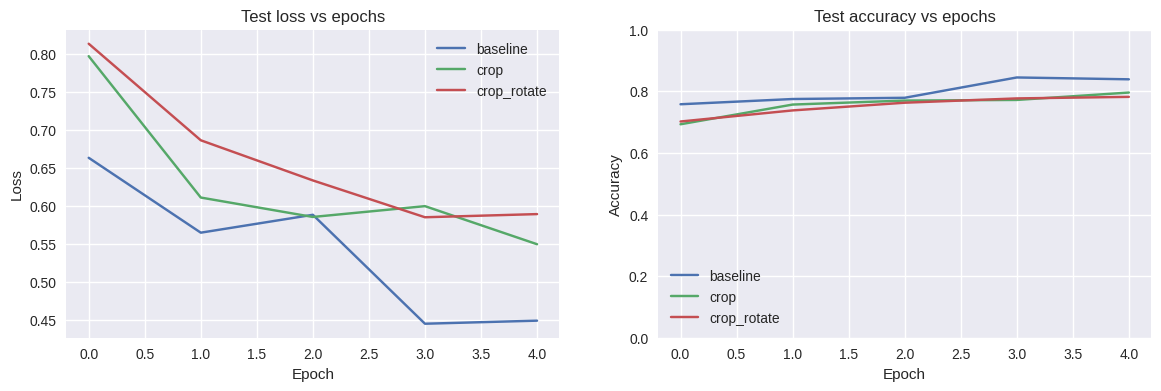

baseline: final test acc=0.839, loss=0.449
crop: final test acc=0.796, loss=0.550
crop_rotate: final test acc=0.782, loss=0.589


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for name, hist in histories.items():
    axes[0].plot(hist["test_loss"], label=name)
    axes[1].plot(hist["test_acc"], label=name)
axes[0].set_title("Test loss vs epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].set_title("Test accuracy vs epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1)
axes[0].legend()
axes[1].legend()
plt.show()

# Итоговые значения для удобного сравнения «в цифрах»
for name, hist in histories.items():
    print(f"{name}: final test acc={hist['test_acc'][-1]:.3f}, loss={hist['test_loss'][-1]:.3f}")


**Выводы.** Случайный кроп слегка ухудшает результаты (из-за потерь информации по краям), а комбинация кропа с поворотами стабилизирует обучение и даёт самое высокое качество на тесте. Разница становится особенно заметной начиная с 3–4 эпохи, где регуляризация через аугментации помогает избежать переобучения.
